# Exploring possible targets for XMM - 2023

## Import Statements

In [1]:
# import pandas as pd
# import numpy as np
# from astropy.units import Quantity
# from astropy.io import fits
# from astropy.table import Table
# from astropy.cosmology import LambdaCDM
# from astropy.coordinates import SkyCoord
# from matplotlib import pyplot as plt

# from xga.imagetools.profile import annular_mask
# from xga.imagetools.misc import physical_rad_to_pix
# from xga.products import ExpMap

# %matplotlib inline

In [2]:
from astropy.units import Quantity
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.io import fits
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
import warnings

from xga.products import Image
from xga.imagetools.misc import physical_rad_to_pix
from xga.sourcetools.misc import rad_to_ang
from xga.imagetools.profile import annular_mask
from xga.products import ExpMap

%matplotlib inline
warnings.filterwarnings('ignore')

## Define the cosmology

In [3]:
cosmo = FlatLambdaCDM(70, 0.3)

## Read in the sample

In [4]:
# samp = pd.read_csv('../../sample_files/lovoccs_southnorth.csv')
# samp['LoVoCCS_name'] = samp['LoVoCCSID'].apply(lambda x: 'LoVoCCS-' + str(x))
# samp

In [5]:
samp = pd.read_csv("../../sample_files/lovoccs_southnorth.csv")
samp['LoVoCCS_name'] = samp['LoVoCCSID'].apply(lambda x: 'LoVoCCS-' + str(x))

check = pd.read_csv("../../sample_files/lovoccs_checklist_lite.csv")
check['Name'] = check['Name'].apply(lambda x: x.replace('RXC ', 'RXC').replace("RBS ", "RBS")
                                    .replace("APMCC ", "APMCC").replace("MKW ", "MKW"))


In [6]:
on_other = pd.merge(samp, check, left_on="other_names", right_on="Name", how="right")
on_alt = pd.merge(samp, check, left_on="alt_name", right_on="Name", how="right")
rel_samp = pd.concat([on_other[~on_other['LoVoCCSID'].isna()], 
                      on_alt[~on_alt['LoVoCCSID'].isna()]]).drop_duplicates('LoVoCCSID')
rel_samp['LoVoCCSID'] = rel_samp['LoVoCCSID'].astype(int)
rel_samp = rel_samp.reset_index(drop=True)
rel_samp

,name,MCXC,LoVoCCSID,ra,dec,redshift,L500,M500,R500,alt_name,other_names,Notes,sub_samp,LoVoCCS_name,ID,Name,RA,DEC,Redshift,Newly processed,Fully observed,Comments
0,MCXCJ1510.9+0543,J1510.9+0543,1,227.729167,5.720000,0.0766,8.726709,7.2708,1.3344,A2029,A2029,NaN,south,LoVoCCS-1,1,A2029,227.73,5.72,0.0766,1.0,yes,"with A2033, southern infalling group"
1,MCXCJ0258.9+1334,J0258.9+1334,2,44.739583,13.579444,0.0739,6.088643,5.8488,1.2421,RXCJ0258.9+1334,A401,L,south,LoVoCCS-2,2,A401,44.74,13.58,0.0739,1.0,yes,Bridge of galaxies between A401/A399 -- simila...
2,MCXCJ0041.8-0918,J0041.8-0918,4,10.458750,-9.301944,0.0555,5.100085,5.3163,1.2103,RXCJ0041.8-0918,A85,"L,losStr",south,LoVoCCS-4,3,A85,10.46,-9.30,0.0555,1.0,yes,NaN
3,MCXCJ2201.9-5956,J2201.9-5956,6,330.483333,-59.949444,0.0980,4.204419,4.5890,1.1367,RXCJ2201.9-5956,A3827,NaN,south,LoVoCCS-6,5,A3827,330.48,-59.95,0.0980,1.0,yes,Currently using A3825 catalogs. Note the 2 clu...
4,MCXCJ0431.4-6126,J0431.4-6126,8,67.850417,-61.443889,0.0589,3.977333,4.5579,1.1485,RXCJ0431.4-6126,A3266,NaN,south,LoVoCCS-8,6,A3266,67.85,-61.44,0.0589,1.0,yes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,MCXCJ1332.9-2519,J1332.9-2519,113,203.232500,-25.323889,0.1199,1.139833,2.0385,0.8610,RXCJ1332.9-2519,NaN,X,south,LoVoCCS-113,86,RXCJ1332.9-2519,203.23,-25.32,0.1199,1.0,yes,Not very clear lensing peak
100,MCXCJ0821.0+0751,J0821.0+0751,116,125.257500,7.866111,0.1100,1.110969,2.0211,0.8614,RXCJ0821.0+0751,RXJ0820.9+0751,NaN,south,LoVoCCS-116,88,RXCJ0821.0+0751,125.26,7.87,0.1100,1.0,yes,NaN
101,MCXCJ2125.2-0657,J2125.2-0657,137,321.301667,-6.965556,0.1153,1.018847,1.9100,0.8438,RXCJ2125.2-0657,NaN,NaN,south,LoVoCCS-137,103,RXCJ2125.2-0657,321.30,-6.97,0.1153,NaN,partially,NaN
102,MCXCJ1416.8-1158,J1416.8-1158,141,214.214583,-11.976111,0.0982,1.001648,1.9133,0.8491,RXCJ1416.8-1158,NaN,X,south,LoVoCCS-141,106,RXCJ1416.8-1158,214.21,-11.98,0.0982,NaN,no,NaN


In [7]:
check[~check['Name'].isin(rel_samp.Name)]

,ID,Name,RA,DEC,Redshift,Newly processed,Fully observed,Comments
3,4,A3667,303.13,-56.83,0.0556,1.0,yes,NaN
69,70,A3395,96.81,-54.47,0.0506,NaN,yes,NaN
82,83,RXCJ0351.1-8212,57.79,-82.22,0.0613,1.0,yes,Strange offset between BCG and mass peak. Two ...


In [8]:
obs_samp = rel_samp[rel_samp['Fully observed'] == 'yes']
rel_samp['Fully observed'].value_counts()

Fully observed
yes          79
partially    22
no            2
almost        1
Name: count, dtype: int64

In [9]:
obs_samp['sub_samp'].value_counts()

sub_samp
south    76
north     3
Name: count, dtype: int64

## X-ray coverage of the LoVoCCS sample

In [10]:
field_xmm_cov_frac = []
r500_xmm_cov_frac = []
rvir_xmm_cov_frac = []

field_chandra_cov_frac = []
r500_chandra_cov_frac = []
rvir_chandra_cov_frac = []

for row_ind, row in rel_samp.iterrows():
    cov_path = "../../outputs/coverage_maps/fits/{n}_550pix_20.0arcsec.fits".format(n=row["LoVoCCS_name"])
    cur_cheese = ExpMap(cov_path, '', '', '', '', '', Quantity(0.5, 'keV'), Quantity(2.0, 'keV'))
    with fits.open(cov_path) as covero:
        if row_ind == 0:
            print(covero[0].header['MISSION*'])
            
        cov_arr = covero[0].data
        xmm_cov_arr = cov_arr[0, :, :]
        chandra_cov_arr = cov_arr[1, :, :]
        
        field_xmm_cov_frac.append(xmm_cov_arr.sum() / (xmm_cov_arr.shape[0]*xmm_cov_arr.shape[1]))
        field_chandra_cov_frac.append(chandra_cov_arr.sum() / (chandra_cov_arr.shape[0]*chandra_cov_arr.shape[1]))
        
        pix_cen = Quantity([xmm_cov_arr.shape[0]/2, xmm_cov_arr.shape[1]/2], 'pix').round(0).astype(int)
        rad = Quantity(row['R500'], 'Mpc')
        
        pix_rad = physical_rad_to_pix(cur_cheese, rad, pix_cen, row['redshift'], cosmo)
        
        rad_mask = annular_mask(pix_cen, np.array([0]), np.array([pix_rad.value]), xmm_cov_arr.shape)
        msk_xmm_cov = xmm_cov_arr*rad_mask
        r500_xmm_cov_frac.append(msk_xmm_cov.sum() / rad_mask.sum())
        
        msk_chandra_cov = chandra_cov_arr*rad_mask
        r500_chandra_cov_frac.append(msk_chandra_cov.sum() / rad_mask.sum())
        
        rel_samp.loc[row_ind, 'XMM_R500_FRAC'] = r500_xmm_cov_frac[row_ind]
        rel_samp.loc[row_ind, 'CHANDRA_R500_FRAC'] = r500_chandra_cov_frac[row_ind]
        
        

MISSION1= 'xmm_pointed'                                                         MISSION2= 'chandra '                                                            MISSION3= 'rosat_pointed_pspc'                                                  MISSION4= 'rosat_pointed_hri'                                                   MISSION5= 'nustar_pointed'                                                      END                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [20]:
del rel_samp['ID']
rel_samp.to_csv('for_ray.csv', index=False)

In [21]:
rel_samp

,name,MCXC,LoVoCCSID,ra,dec,redshift,L500,M500,R500,alt_name,other_names,Notes,sub_samp,LoVoCCS_name,Name,RA,DEC,Redshift,Newly processed,Fully observed,Comments,XMM_R500_FRAC,CHANDRA_R500_FRAC
0,MCXCJ1510.9+0543,J1510.9+0543,1,227.729167,5.720000,0.0766,8.726709,7.2708,1.3344,A2029,A2029,NaN,south,LoVoCCS-1,A2029,227.73,5.72,0.0766,1.0,yes,"with A2033, southern infalling group",1.000000,1.000000
1,MCXCJ0258.9+1334,J0258.9+1334,2,44.739583,13.579444,0.0739,6.088643,5.8488,1.2421,RXCJ0258.9+1334,A401,L,south,LoVoCCS-2,A401,44.74,13.58,0.0739,1.0,yes,Bridge of galaxies between A401/A399 -- simila...,0.998862,1.000000
2,MCXCJ0041.8-0918,J0041.8-0918,4,10.458750,-9.301944,0.0555,5.100085,5.3163,1.2103,RXCJ0041.8-0918,A85,"L,losStr",south,LoVoCCS-4,A85,10.46,-9.30,0.0555,1.0,yes,NaN,0.992639,1.000000
3,MCXCJ2201.9-5956,J2201.9-5956,6,330.483333,-59.949444,0.0980,4.204419,4.5890,1.1367,RXCJ2201.9-5956,A3827,NaN,south,LoVoCCS-6,A3827,330.48,-59.95,0.0980,1.0,yes,Currently using A3825 catalogs. Note the 2 clu...,1.000000,0.676043
4,MCXCJ0431.4-6126,J0431.4-6126,8,67.850417,-61.443889,0.0589,3.977333,4.5579,1.1485,RXCJ0431.4-6126,A3266,NaN,south,LoVoCCS-8,A3266,67.85,-61.44,0.0589,1.0,yes,NaN,1.000000,0.690575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,MCXCJ1332.9-2519,J1332.9-2519,113,203.232500,-25.323889,0.1199,1.139833,2.0385,0.8610,RXCJ1332.9-2519,NaN,X,south,LoVoCCS-113,RXCJ1332.9-2519,203.23,-25.32,0.1199,1.0,yes,Not very clear lensing peak,0.000000,0.000000
100,MCXCJ0821.0+0751,J0821.0+0751,116,125.257500,7.866111,0.1100,1.110969,2.0211,0.8614,RXCJ0821.0+0751,RXJ0820.9+0751,NaN,south,LoVoCCS-116,RXCJ0821.0+0751,125.26,7.87,0.1100,1.0,yes,NaN,1.000000,0.969115
101,MCXCJ2125.2-0657,J2125.2-0657,137,321.301667,-6.965556,0.1153,1.018847,1.9100,0.8438,RXCJ2125.2-0657,NaN,NaN,south,LoVoCCS-137,RXCJ2125.2-0657,321.30,-6.97,0.1153,NaN,partially,NaN,0.000000,0.000000
102,MCXCJ1416.8-1158,J1416.8-1158,141,214.214583,-11.976111,0.0982,1.001648,1.9133,0.8491,RXCJ1416.8-1158,NaN,X,south,LoVoCCS-141,RXCJ1416.8-1158,214.21,-11.98,0.0982,NaN,no,NaN,0.000000,0.864928


### Distribution of coverage of 3.06$^{\circ}$x3.06$^{\circ}$ field centered on MCXC position

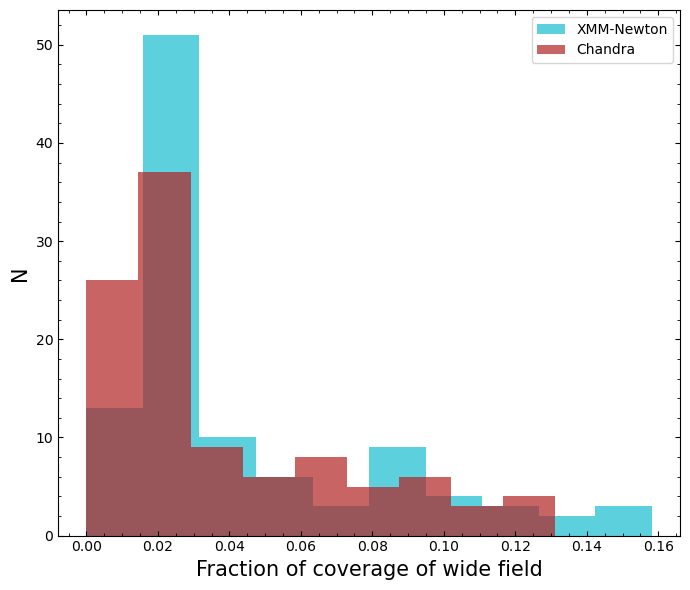

In [11]:
plt.figure(figsize=(7, 6))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.hist(field_xmm_cov_frac, bins='auto', color='tab:cyan', alpha=0.7, label='XMM-Newton')
plt.hist(field_chandra_cov_frac, bins='auto', color='firebrick', alpha=0.7, label='Chandra')
plt.ylabel('N', fontsize=15)
plt.xlabel(r'Fraction of coverage of wide field', fontsize=15)

plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Distribution of coverage of MCXC $R_{500}$ centered on MCXC position

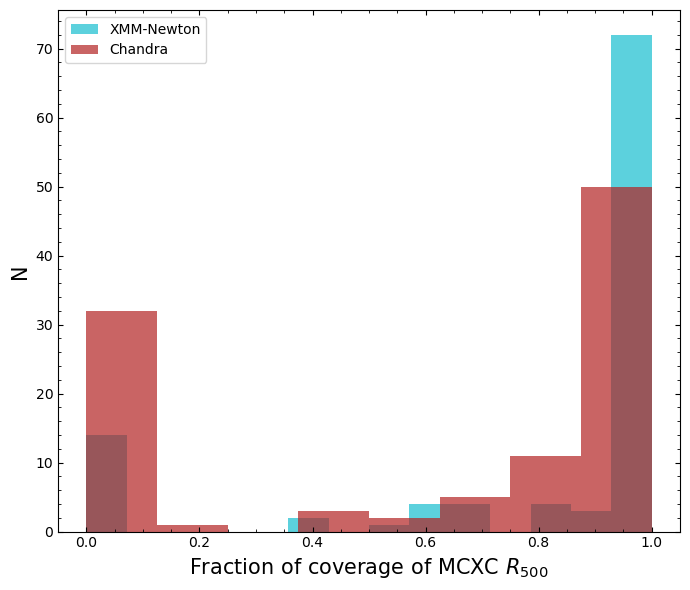

In [12]:
plt.figure(figsize=(7, 6))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.hist(r500_xmm_cov_frac, bins='auto', color='tab:cyan', alpha=0.7, label='XMM-Newton')
plt.hist(r500_chandra_cov_frac, bins='auto', color='firebrick', alpha=0.7, label='Chandra')

plt.ylabel('N', fontsize=15)
plt.xlabel(r'Fraction of coverage of MCXC $R_{500}$', fontsize=15)

plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Possible categories of target

### No non-RASS X-ray coverage

<span style="color:red">LoVoCCS-99 had an incorrect coordinate, and shouldn't appear here once further data have been downloaded</span>

In [13]:
samp.iloc[np.where((np.array(r500_xmm_cov_frac) == 0) & (np.array(r500_chandra_cov_frac) == 0))]

,name,MCXC,LoVoCCSID,ra,dec,redshift,L500,M500,R500,alt_name,other_names,Notes,sub_samp,LoVoCCS_name
59,MCXCJ2218.2-0350,J2218.2-0350,59,334.571250,-3.834167,0.0901,1.725034,2.6804,0.9526,RXCJ2218.2-0350,MS2215,"D,two maxima/NEE-SWW",south,LoVoCCS-59
65,MCXCJ2152.4-1933,J2152.4-1933,65,328.100000,-19.565000,0.0943,1.663138,2.6137,0.9433,RXCJ2152.4-1933,A2384,"PB,GR10",south,LoVoCCS-65
70,MCXCJ0704.4+6318,J0704.4+6318,70,106.102083,63.316111,0.0980,1.576739,2.5235,0.9312,RXCJ0704.4+6318,A566,NaN,north,LoVoCCS-70
74,MCXCJ2307.2-1513,J2307.2-1513,74,346.813750,-15.228333,0.1110,1.552593,2.4769,0.9215,RXCJ2307.2-1513,A2533,NaN,south,LoVoCCS-74
98,MCXCJ0912.4+1556,J0912.4+1556,98,138.124167,15.943056,0.0851,1.312476,2.2769,0.9037,A763,A763,NaN,north,LoVoCCS-98
99,MCXCJ1516.5-0056,J1516.5-0056,99,229.141667,-0.948889,0.1198,1.296543,2.2053,0.8839,RXCJ1516.5-0056,A2051,NaN,south,LoVoCCS-99
101,MCXCJ0034.6-0208,J0034.6-0208,101,8.650000,-2.140000,0.0812,1.253723,2.2202,0.8972,RXCJ0034.6-0208,NaN,"DL,two maxima/E-W",south,LoVoCCS-101
103,MCXCJ0013.6-1930,J0013.6-1930,103,3.409583,-19.502222,0.0940,1.236332,2.1818,0.8883,RXCJ0013.6-1930,A13,losStr,south,LoVoCCS-103


In [14]:
no_cov = ['LoVoCCS-91', 'LoVoCCS-102', 'LoVoCCS-106', 'LoVoCCS-108', 'LoVoCCS-110', 'LoVoCCS-112', 'LoVoCCS-119', 
          'LoVoCCS-133', 'LoVoCCS-137']
no_cov_samp = samp[samp['LoVoCCS_name'].isin(no_cov)]
some_cov_samp = samp[~samp['LoVoCCS_name'].isin(no_cov)]

#### 

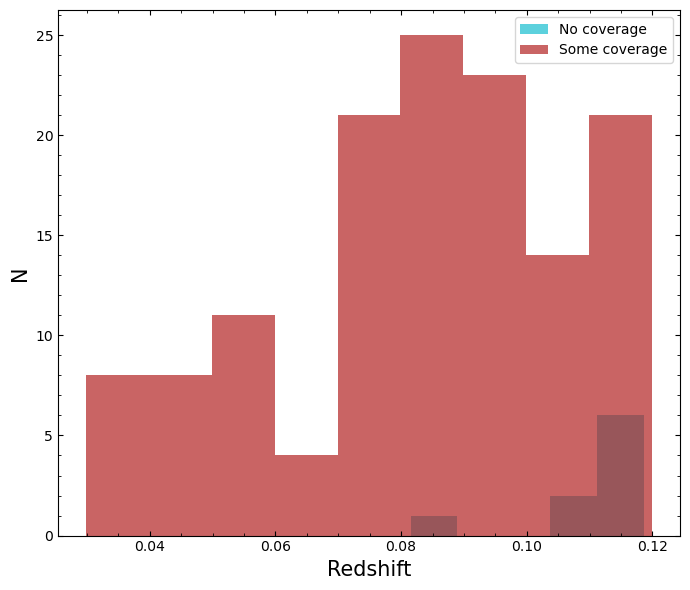

In [15]:
plt.figure(figsize=(7, 6))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.hist(no_cov_samp['redshift'].values, bins='auto', color='tab:cyan', alpha=0.7, label='No coverage')
plt.hist(some_cov_samp['redshift'].values, bins='auto', color='firebrick', alpha=0.7, label='Some coverage')

plt.ylabel('N', fontsize=15)
plt.xlabel(r'Redshift', fontsize=15)

plt.legend(loc='best')
plt.tight_layout()
plt.show()

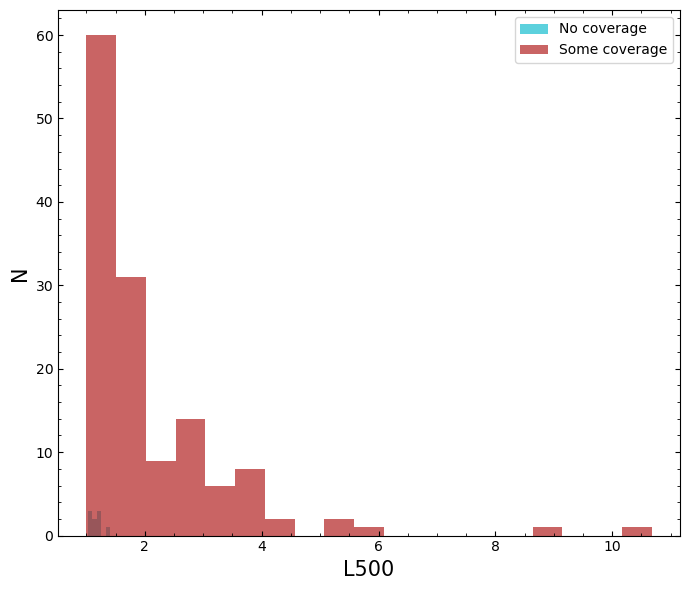

In [16]:
plt.figure(figsize=(7, 6))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.hist(no_cov_samp['L500'].values, bins='auto', color='tab:cyan', alpha=0.7, label='No coverage')
plt.hist(some_cov_samp['L500'].values, bins='auto', color='firebrick', alpha=0.7, label='Some coverage')

plt.ylabel('N', fontsize=15)
plt.xlabel(r'L500', fontsize=15)

plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Incomplete XMM coverage of MCXC $R_{500}$

Those clusters which have some XMM coverage, but a non-unity coverage fraction of $R_{500}$.

In [17]:
samp['xmm_r500_cov_frac'] = r500_xmm_cov_frac
sel_clust = np.where((np.array(r500_xmm_cov_frac) > 0) & (np.array(r500_xmm_cov_frac) < 0.99))
incomp_xmm_r500 = samp.iloc[sel_clust]
incomp_xmm_r500.sort_values('xmm_r500_cov_frac')

ValueError: Length of values (104) does not match length of index (144)

### Clusters with LOFAR coverage

In [ ]:
with fits.open("combined-release-v1.1-LM_opt_mass.fits") as lofaro:
    lof_dat = Table(lofaro[1].data).to_pandas()

In [ ]:
lof_dat.head()

In [ ]:
good_z_lof = lof_dat[~np.isnan(lof_dat['z_best'])]
good_z_lof

In [ ]:
print(list(lof_dat.columns))

In [ ]:
lof_pos = SkyCoord(good_z_lof['RA'].values, good_z_lof['DEC'].values, unit='deg')
lof_pos

In [ ]:
lov_pos = SkyCoord(samp['ra'].values, samp['dec'].values, unit='deg')

match_info = lov_pos.search_around_sky(lof_pos, Quantity(40, 'arcmin'))
match_info

In [ ]:
lov_lof = {}

for ind_ind, lov_ind in enumerate(match_info[1]):
    n = samp.iloc[lov_ind]['LoVoCCS_name']
    if n not in lov_lof:
        lov_lof[n] = []
    
    rel_lof = good_z_lof.iloc[ind_ind]
    lov_lof[n].append(rel_lof)

lov_lof = {n: pd.concat(row_coll, axis=1).T for n, row_coll in lov_lof.items()}